In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import math
from layers import FreeSpacePropagation
import time
import pandas as pd
import cv2
from cxlayers import AngularSpectrum, ImageResizing, ImageToElectricField, ImageBinarization, CxMO, CxD2NNFaradayRotation, CxD2NNIntensity, D2NNMNISTDetector, Polarizer

tf.experimental.numpy.experimental_enable_numpy_behavior()

plt.rcParams["font.size"]=18

In [2]:
mnist = tf.keras.datasets.mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train / 255.0
x_test = x_test / 255.0

In [5]:
train_num = 10
test_num = 10
total = train_num + test_num
train_data = {}
test_data = {}
for i in range(10):
  train_data[str(i)] = x_train[np.where(y_train == i)][0:train_num]
  test_data[str(i)] = x_test[np.where(y_test == i)][0:test_num]

In [11]:
shape = (100, 100)

inputs = tf.keras.Input((28, 28))
x = ImageResizing(shape)(inputs)
x = ImageBinarization(0.5, 0.0, 1.0)(x)
x = ImageToElectricField(shape)(x)
# x = CxMO(shape)(x)
x = AngularSpectrum(shape, 531e-9, 0.0e-3, d=1.0e-6, method='expand')(x)
# x = CxD2NNFaradayRotation(shape)(x)
x = CxD2NNIntensity(shape)(x)
model = tf.keras.Model(inputs, x)
model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 28, 28)]          0         
                                                                 
 image_resizing_3 (ImageResi  (None, 100, 100)         0         
 zing)                                                           
                                                                 
 image_binarization_3 (Image  (None, 100, 100)         0         
 Binarization)                                                   
                                                                 
 image_to_electric_field_3 (  (None, 2, 2, 100, 100)   0         
 ImageToElectricField)                                           
                                                                 
 angular_spectrum_3 (Angular  (None, 2, 2, 100, 100)   0         
 Spectrum)                                                 

In [16]:
pred = model.predict(test_data['7'])
image = np.ones((1, 28, 28))
pred = model.predict(image)
plt.imshow(pred[8,:,:])
# plt.colorbar()

IndexError: index 8 is out of bounds for axis 0 with size 1

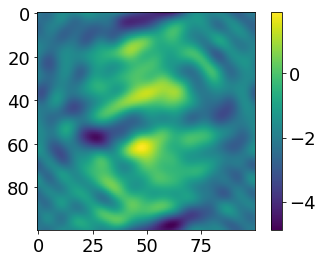

In [36]:
pahse = np.loadtxt('data/phase/100px/train_5.csv')
pahse = np.where(pahse > 0.5 , 1, -1) * 2.1 * np.pi / 180
model.layers[2].set_weights([pahse])
pred = model.predict(np.ones([1,100,100]))
plt.imshow(pred[0,:,:] * 180 / np.pi)
plt.colorbar()

2022-03-31 15:24:25.422164: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-03-31 15:24:25.468024: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


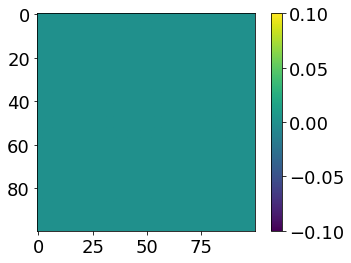

In [3]:
one = np.ones((1, 100, 100))
pred = model.predict(one)
plt.imshow(pred[0,:,:] * 180/np.pi)
plt.colorbar()

In [110]:
one = np.ones((1,28, 28)) * 6
pred = model.predict(one)
rcp_x = pred[0,0,0,:,:,]
rcp_y = pred[0,0,1,:,:,]
lcp_x = pred[0,1,0,:,:,]
lcp_y = pred[0,1,1,:,:,]

rcp_i = np.abs(rcp_x)**2/2 + np.abs(rcp_y)**2/2
lcp_i = np.abs(lcp_x)**2/2 + np.abs(lcp_y)**2/2
i = np.abs(rcp_x + lcp_x)**2/2 + np.abs(rcp_y + lcp_y)**2/2
i

array([[5.9999995, 5.9999995, 5.9999995, ..., 5.9999995, 5.9999995,
        5.9999995],
       [5.9999995, 5.9999995, 5.9999995, ..., 5.9999995, 5.9999995,
        5.9999995],
       [5.9999995, 5.9999995, 5.9999995, ..., 5.9999995, 5.9999995,
        5.9999995],
       ...,
       [5.9999995, 5.9999995, 5.9999995, ..., 5.9999995, 5.9999995,
        5.9999995],
       [5.9999995, 5.9999995, 5.9999995, ..., 5.9999995, 5.9999995,
        5.9999995],
       [5.9999995, 5.9999995, 5.9999995, ..., 5.9999995, 5.9999995,
        5.9999995]], dtype=float32)

In [7]:
one = np.ones((1,28, 28)) * 4
pred = model.predict(one)
pred

array([[[4.0000005, 4.0000005, 4.0000005, ..., 4.0000005, 4.0000005,
         4.0000005],
        [4.0000005, 4.0000005, 4.0000005, ..., 4.0000005, 4.0000005,
         4.0000005],
        [4.0000005, 4.0000005, 4.0000005, ..., 4.0000005, 4.0000005,
         4.0000005],
        ...,
        [4.0000005, 4.0000005, 4.0000005, ..., 4.0000005, 4.0000005,
         4.0000005],
        [4.0000005, 4.0000005, 4.0000005, ..., 4.0000005, 4.0000005,
         4.0000005],
        [4.0000005, 4.0000005, 4.0000005, ..., 4.0000005, 4.0000005,
         4.0000005]]], dtype=float32)

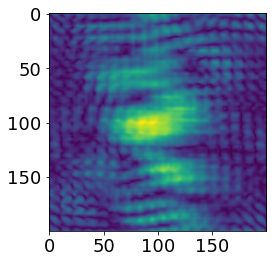

In [19]:
image = cv2.resize(x_train[0,:,:],(100, 100))
wavelength = 531e-9
z = 4.0e-3
image_pad = np.pad(image, [[50,50],[50,50]])
image_pad_fft = np.fft.fft2(image_pad)
u = np.fft.fftfreq(100*2, d=1.0e-6)
v = np.fft.fftfreq(100*2, d=1.0e-6)
UU, VV = np.meshgrid(u,v)
w = np.sqrt(1/wavelength**2 - UU**2 - VV**2)
h = np.exp(1.0j * 2 * np.pi * w*z)
gz = np.fft.ifft2(image_pad_fft * h)
plt.imshow(np.abs(gz))